In [2]:
run run_residuals -v -o 2


Initialization runtime 12.92 s
Number of stars 484

Maximum SNR before correction 200.00
SNR correction runtime 0.07 s
Maximum SNR before correction 200.00

Nonzero Minimum SNR before mask 50.0000
SNR cut runtime 0.00 s
Minimum SNR after mask 50.0000

Bitmask application runtime 0.00 s

Pixel residuals runtime 0.34 s
Maximum residual 0.1938813389 

Finding random sigma runtime 0.34 s



/Users/Natalie/Code/apogee/apogee/spec/window.py:88: RuntimeWarning: invalid value encountered in greater
  mask= ((win > 0.)*(True-numpy.isnan(win))).astype('int')


In [3]:
import numpy as np
from lowess import lowess
import matplotlib
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 18}

matplotlib.rc('font', **font)
import matplotlib.patheffects as path_effects
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [4]:
def calc_cov(model,subgroups=None):
    """
    Calculates the covariance matrix of fit residuals divided by measurement uncertainty.
    
    If subgroups are given, returns the covariance matrix of combined subgroups as well as each one individually.
    If no subgroups are given, returns one matrix.
    """
    
    if subgroups:
        covs = ()
        totalstars = 0
        for subgroup in subgroups:
            totalstars += model.numstars[subgroup]
        allresids = np.ma.masked_array(np.zeros((totalstars,aspcappix)))
        allerrors = np.ma.masked_array(np.zeros((totalstars,aspcappix)))
        star = 0
        for subgroup in subgroups:
            match = np.where(model.data[model.subgroup]==subgroup)
            res = model.residual[subgroup]
            err = model.errs[match].T
            covs += (np.ma.cov(res/err),)
            allresids[star:star+model.numstars[subgroup]] = res.T
            allerrors[star:star+model.numstars[subgroup]] = err.T
            star+=starsample.numstars[subgroup]          
    elif not subgroups:
        covs = ()
        allresids = model.residual.T
        allerrors = model.errs
    covs += (np.ma.cov(allresids.T/allerrors.T),)
    return covs

def diagonals(covs):
    diagonals = ()
    for cov in covs:
        diagonal = np.ma.masked_array([cov[i,i] for i in range(len(cov))])
        diagonals += (diagonal,)
    return diagonals
    
            
            
            

In [5]:
clusterlist = ['M67','N6819']

In [6]:
covs = calc_cov(starsample,clusterlist)

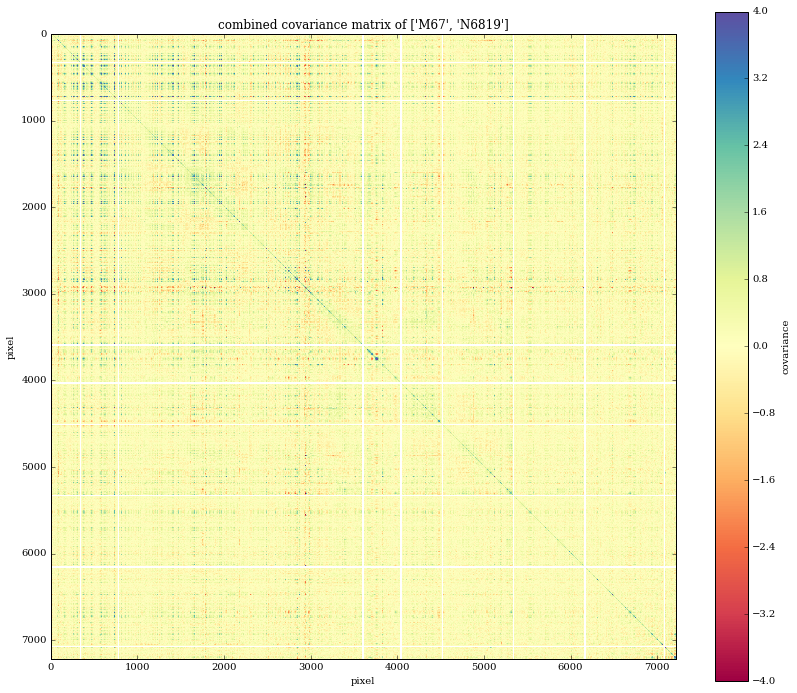

In [7]:
limit = 4
plt.figure(figsize = (14,12))
plt.imshow(covs[-1],vmin=-limit,vmax=limit,interpolation='nearest',cmap = 'Spectral')
plt.colorbar(label='covariance')
plt.xlabel('pixel')
plt.ylabel('pixel')
plt.title('combined covariance matrix of {0}'.format(clusterlist))

In [8]:
diags = diagonals(covs)

/Users/Natalie/anaconda/lib/python2.7/site-packages/numpy/ma/core.py:4085: UserWarning: Warning: converting a masked element to nan.
  warnings.warn("Warning: converting a masked element to nan.")



In [9]:
smoothmedian = lowess(np.arange(aspcappix)[diags[-1].mask==False],diags[-1][diags[-1].mask==False],f=2./3.,iter=3)

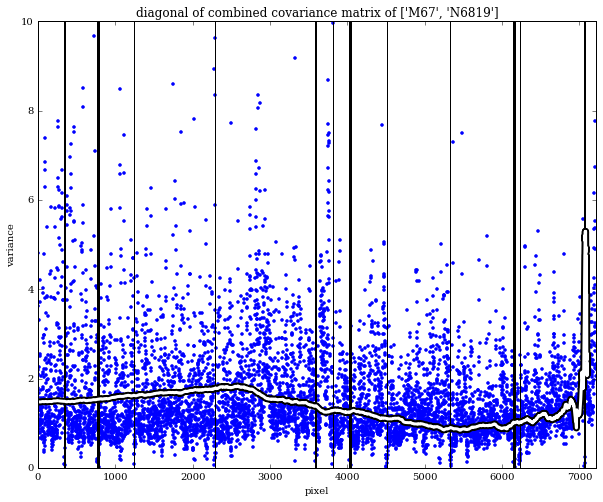

In [10]:
plt.figure(figsize=(10,8))
plt.plot(diags[-1],'.')
for maskedelem in np.where(diags[-1].mask==True)[0]:
    plt.axvline(maskedelem,color='k')
plt.plot(smoothmedian,'w-',linewidth=3,path_effects=[path_effects.withStroke(linewidth=7, foreground="k")],label='running median')
plt.ylim(0,10)
plt.xlim(0,aspcappix)
plt.ylabel('variance')
plt.xlabel('pixel')
plt.title('diagonal of combined covariance matrix of {0}'.format(clusterlist))

In [16]:
acs.pklwrite('clusters/pickles/diagonalcorrect.pkl',diags[-1])

/Users/Natalie/anaconda/lib/python2.7/site-packages/numpy/ma/core.py:836: RuntimeWarning: invalid value encountered in less
  return umath.less(x, self.critical_value)



In [14]:
run run_residuals -vgx -i FE_H -u -0.1 -d -0.105 -s red_clump -c False -C clusters/pickles/diagonalcorrect.pkl


Initialization runtime 2.92 s
Number of stars 194

Maximum SNR before correction 219.82


ValueError: operands could not be broadcast together with shapes (194,7214) () (194,7101) 